### Notebook structure
- Pre-processing
- Basic FB Prophet prediction
- Train vs test - Prophet, score
- LSTM, score
- comparison

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

In [3]:
plt.rcParams['figure.figsize'] = [25.0, 10.0] # change these values to change the graph size throghout this notebook

#### Pre-processing

In [4]:
df = pd.read_csv('tbl_us_combined.csv')

In [5]:
df.columns

Index(['Date', 'WCS- Sales_Accessories', 'Ordered Units_Accessories',
       'Ship Charge_Accessories', 'Ship Tax Amount_Accessories',
       'Tax Amount_Accessories', 'Total Shipping Cost_Accessories',
       'Discount_Accessories', 'WCS- Sales_Footwear', 'Ordered Units_Footwear',
       'Ship Charge_Footwear', 'Ship Tax Amount_Footwear',
       'Tax Amount_Footwear', 'Total Shipping Cost_Footwear',
       'Discount_Footwear', 'WCS- Sales_Apparel', 'Ordered Units_Apparel',
       'Ship Charge_Apparel', 'Ship Tax Amount_Apparel', 'Tax Amount_Apparel',
       'Total Shipping Cost_Apparel', 'Discount_Apparel', 'WCS- Sales_Custom',
       'Ordered Units_Custom', 'Ship Charge_Custom', 'Ship Tax Amount_Custom',
       'Tax Amount_Custom', 'Total Shipping Cost_Custom', 'Discount_Custom',
       'WCS- Sales_Equipment', 'Ordered Units_Equipment',
       'Ship Charge_Equipment', 'Ship Tax Amount_Equipment',
       'Tax Amount_Equipment', 'Total Shipping Cost_Equipment',
       'Discount_Equipme

In [6]:
df.head()

,Date,WCS- Sales_Accessories,Ordered Units_Accessories,Ship Charge_Accessories,Ship Tax Amount_Accessories,Tax Amount_Accessories,Total Shipping Cost_Accessories,Discount_Accessories,WCS- Sales_Footwear,Ordered Units_Footwear,...,# of Product Views,# of Units,# of Visitors,Sales (USD),YoY Avg. Order Value %,Conversion Rate,YoY Conv Rate %,YoY Orders %,AUR,AOV
0,2014-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-,741,"79,562","$72,704.89",NaN,0.66%,NaN,NaN,$98.12,$137.70
1,2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-,958,"95,160","$95,303.42",NaN,0.71%,NaN,NaN,$99.48,$140.98
2,2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-,912,"90,603","$93,321.68",NaN,0.74%,NaN,NaN,$102.33,$139.91
3,2014-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-,802,"92,275","$86,770.02",NaN,0.65%,NaN,NaN,$108.19,$143.90
4,2014-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-,"1,022","101,520","$105,032.88",NaN,0.72%,NaN,NaN,$102.77,$144.08


In [7]:
df.set_index(pd.to_datetime(df['Date'],format="%Y/%m/%d"), inplace=True)
del df['Date']
data = df[[' Sales (USD) ']].copy()
data.columns = ['Sales'] # rename column

In [8]:
sum(data.index.duplicated()) # check for duplicate indices

0

In [9]:
print(data.isna().sum(), data.isna().sum()/data.shape[0]) # count NAs

Sales    74
dtype: int64 Sales    0.059533
dtype: float64


In [10]:
data.head()

,Sales
Date,
2014-01-01,"$72,704.89"
2014-01-02,"$95,303.42"
2014-01-03,"$93,321.68"
2014-01-04,"$86,770.02"
2014-01-05,"$105,032.88"


In [11]:
data.fillna('0', inplace=True)
data.sort_index(inplace=True)
data.Sales.replace('-', '0', regex=True, inplace=True) # there's a dash!
data.Sales.replace('[\$,]', '', regex=True, inplace=True) # remove dollar signs, commas
data.Sales = data.Sales.astype(float)

In [12]:
data.head()

,Sales
Date,
2014-01-01,72704.89
2014-01-02,95303.42
2014-01-03,93321.68
2014-01-04,86770.02
2014-01-05,105032.88


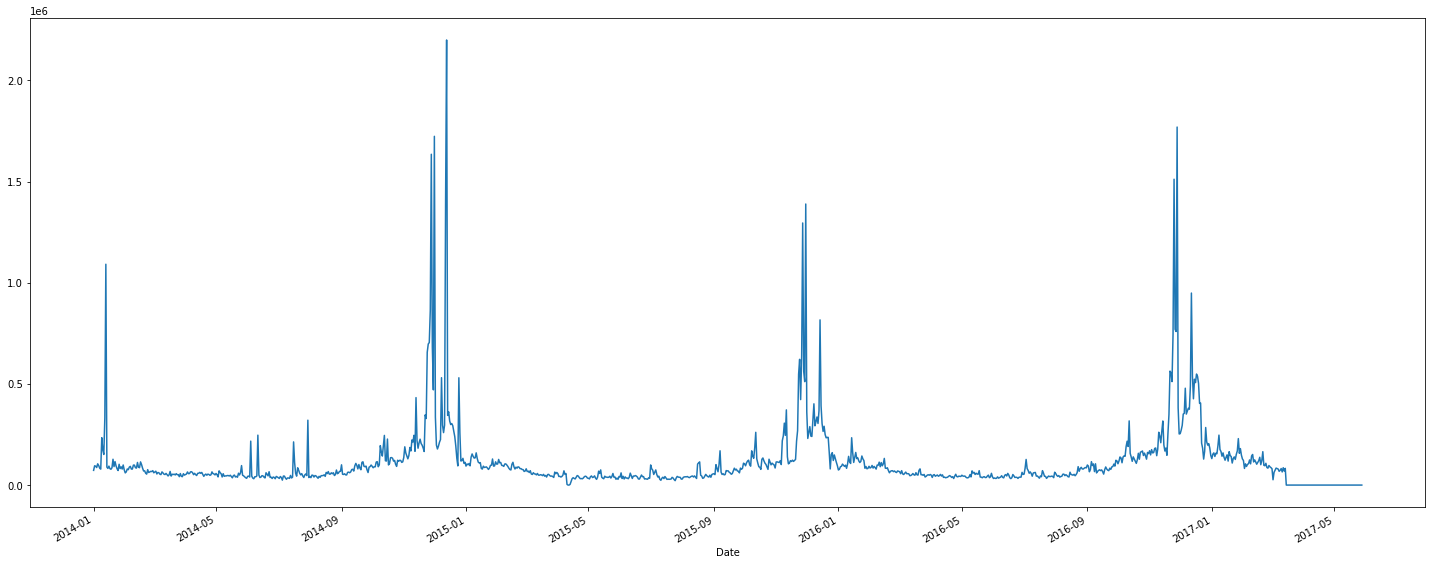

In [13]:
data.Sales.plot();

#### Prophet

In [14]:
df = data.reset_index().rename(columns={"Date": "ds", "Sales": "y"}) # Prophet requires moving the index + renaming columns

In [15]:
df.ds.max()

Timestamp('2017-05-28 00:00:00')

In [16]:
from fbprophet import Prophet

In [18]:
m = Prophet(daily_seasonality=True)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1603,2018-05-24,14651.785590,-138609.465161,156106.099446
1604,2018-05-25,26813.692652,-120542.825045,166520.890236
1605,2018-05-26,14261.353355,-123141.891710,156280.543180
1606,2018-05-27,19085.535715,-125245.197698,170944.476129
1607,2018-05-28,57988.622051,-84265.823138,201999.433666


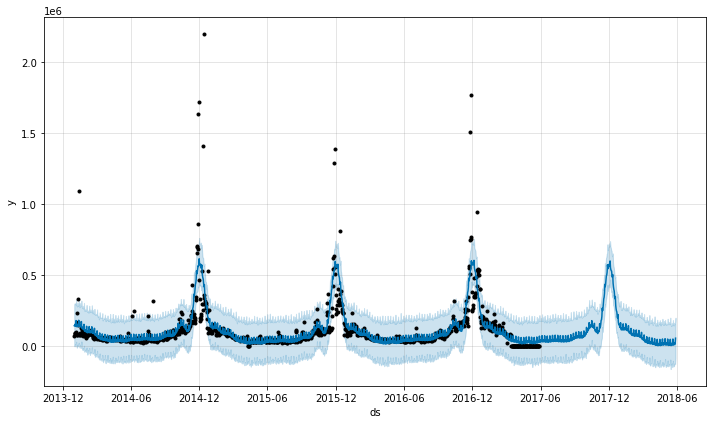

In [20]:
fig1 = m.plot(forecast)

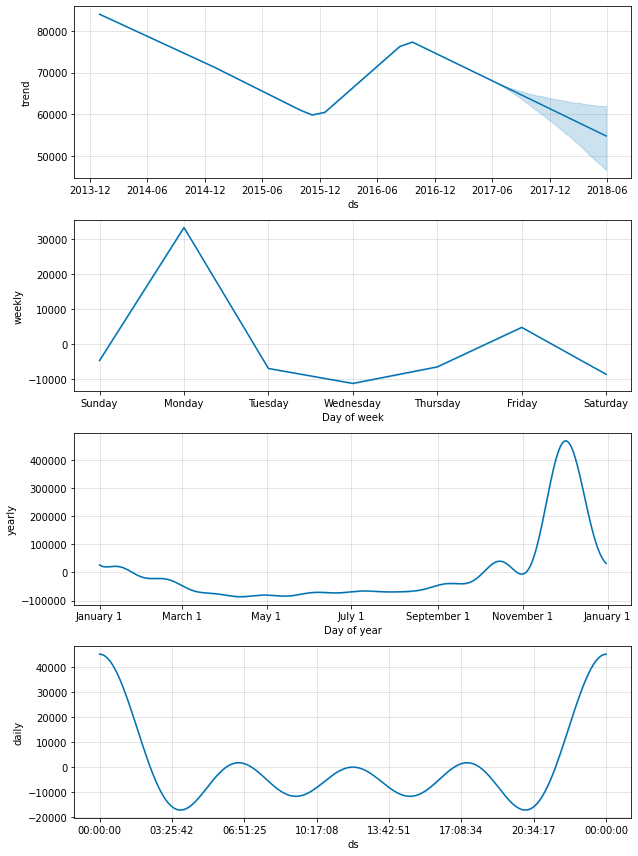

In [21]:
fig2 = m.plot_components(forecast)

#### Prediction on known values

In [22]:
split_date = pd.Timestamp('2015-01-01') # Beginning of the year near the end, since the data is cyclical annually
train = df[df['ds'] < split_date]
test = df[df['ds'] >= split_date]

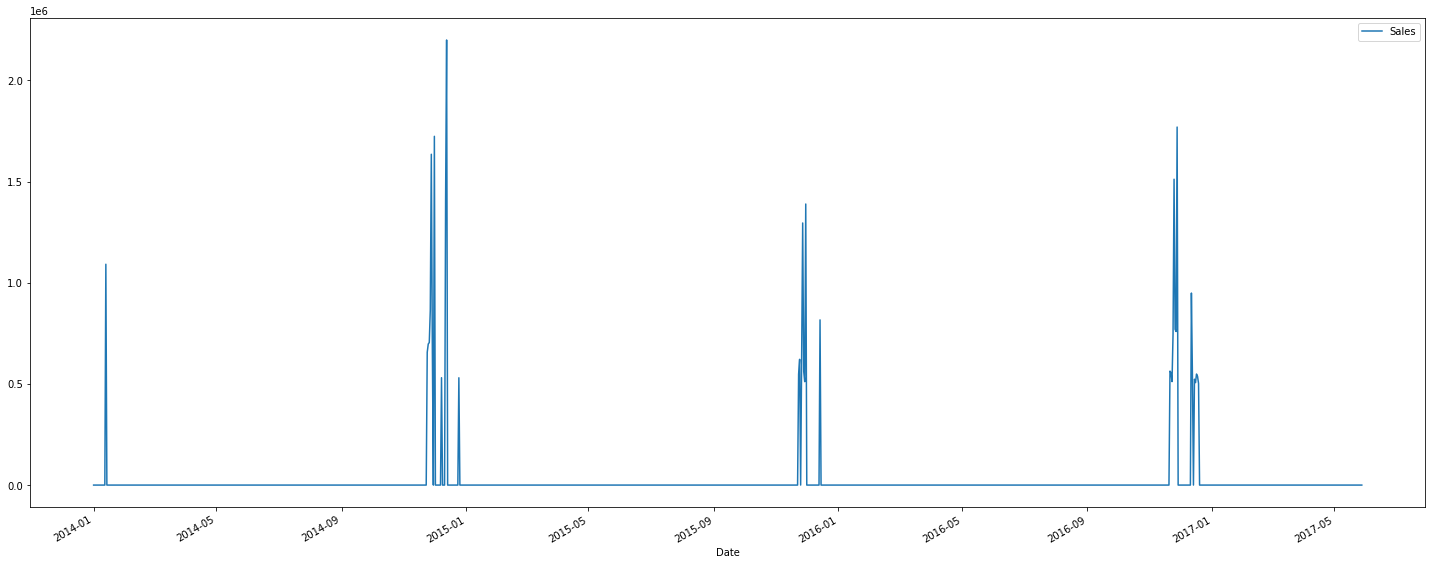

In [23]:
data[data.Sales > 500000].reindex(data.index, fill_value=0).plot();

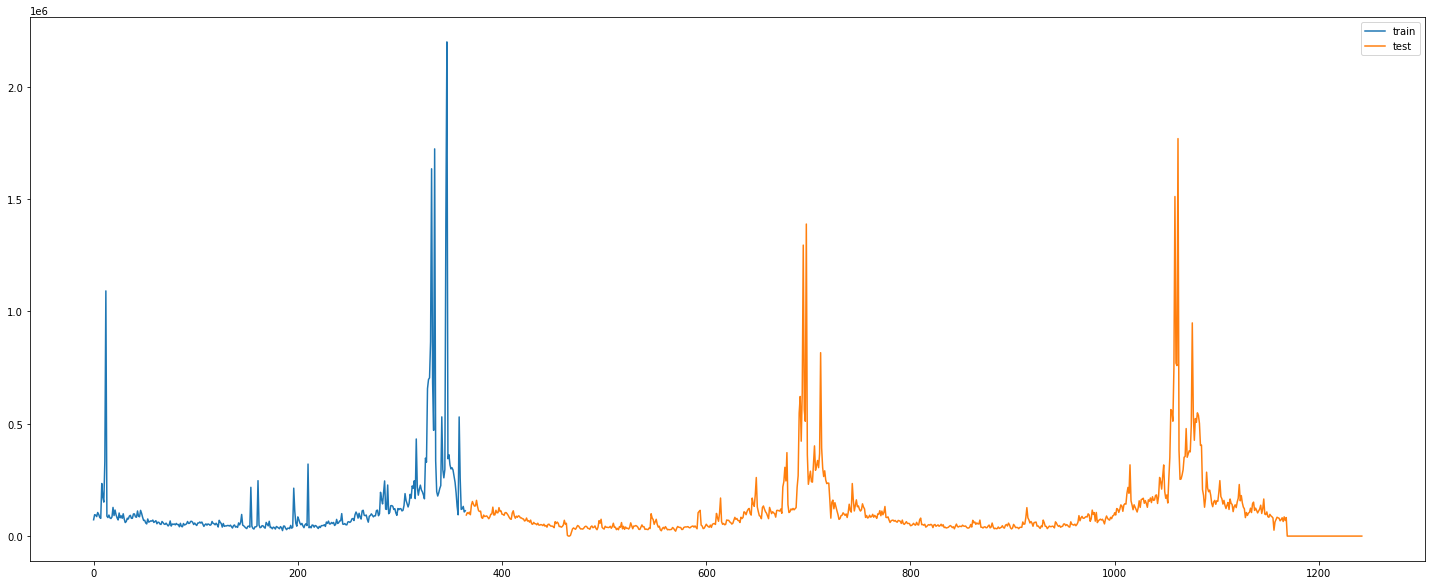

In [24]:
ax = train.y.plot()
test.y.plot(ax=ax)
plt.legend(['train', 'test']);

In [25]:
test.set_index('ds', inplace=True)

In [117]:
# pseudocode
# train on one year data
# then for each n-sized window remaining:
# predict
# add prediction, ground truth, SD of error to table
# retrain on orig + known
# repeat for each n in [7, 14, 30]

In [26]:
test.head()

,y
ds,
2015-01-01,93819.51
2015-01-02,104481.33
2015-01-03,100229.46
2015-01-04,106735.86
2015-01-05,95117.58


In [29]:
forecasts = []
n = 30
split_date = 0
cursor = 5
while len(test) - cursor > n:
    sample = test[cursor:cursor + n]
    forecasts.append(m.predict(m.make_future_dataframe(x, include_history=False)))
    split_date += n
    train = df[df['ds'] < split_date]
    m.fit(train)

In [35]:
from datetime import timedelta

In [40]:
m = Prophet(changepoint_range=0.999, changepoint_prior_scale=0.1, yearly_seasonality=True, daily_seasonality=True, 
            weekly_seasonality=False, )
m.fit(train)
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)
pred = forecast.loc[:,['ds', 'yhat']].copy().set_index('ds')[split_date:]

In [41]:
forecast = Prophet(interval_width=0.95, daily_seasonality=False).fit(df).predict(future)

In [42]:
horizons = [7, 14, 30]
preds = [m.predict(m.make_future_dataframe(x, include_history=False)) for x in horizons]

In [43]:
df.set_index('ds')

,y
ds,
2014-01-01,72704.89
2014-01-02,95303.42
2014-01-03,93321.68
2014-01-04,86770.02
2014-01-05,105032.88
...,...
2017-05-24,0.00
2017-05-25,0.00
2017-05-26,0.00


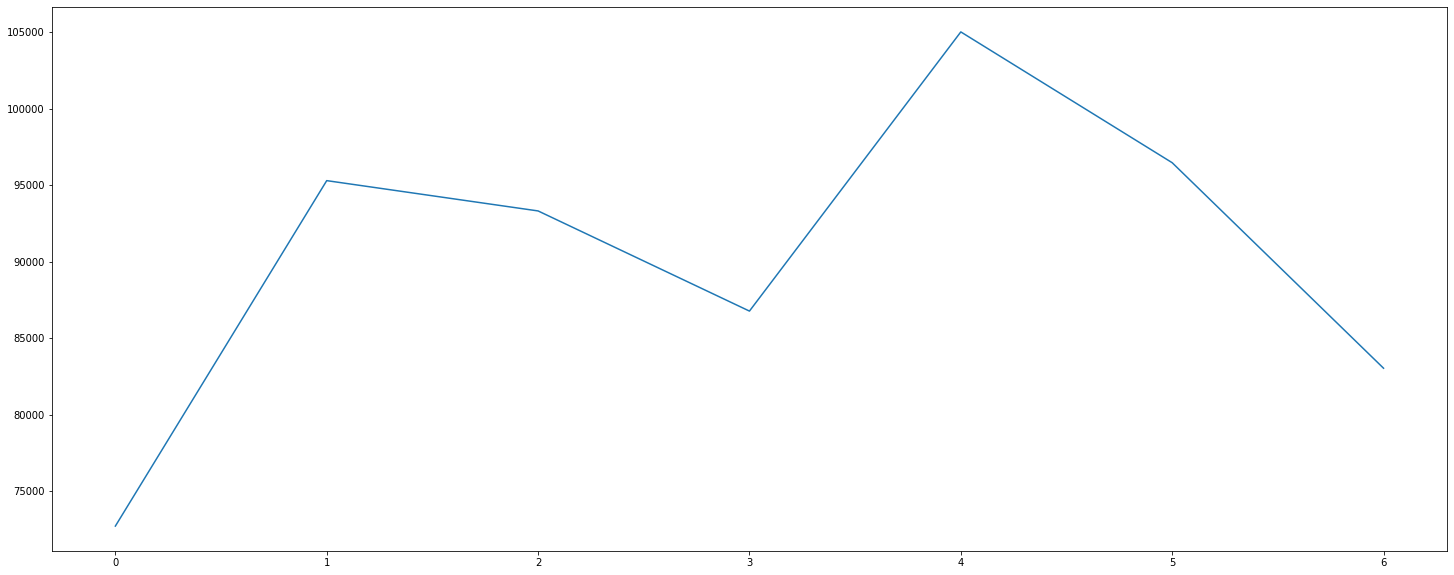

In [45]:
plt.plot(df.iloc[preds[0].loc[:,['ds', 'yhat']].index].y);

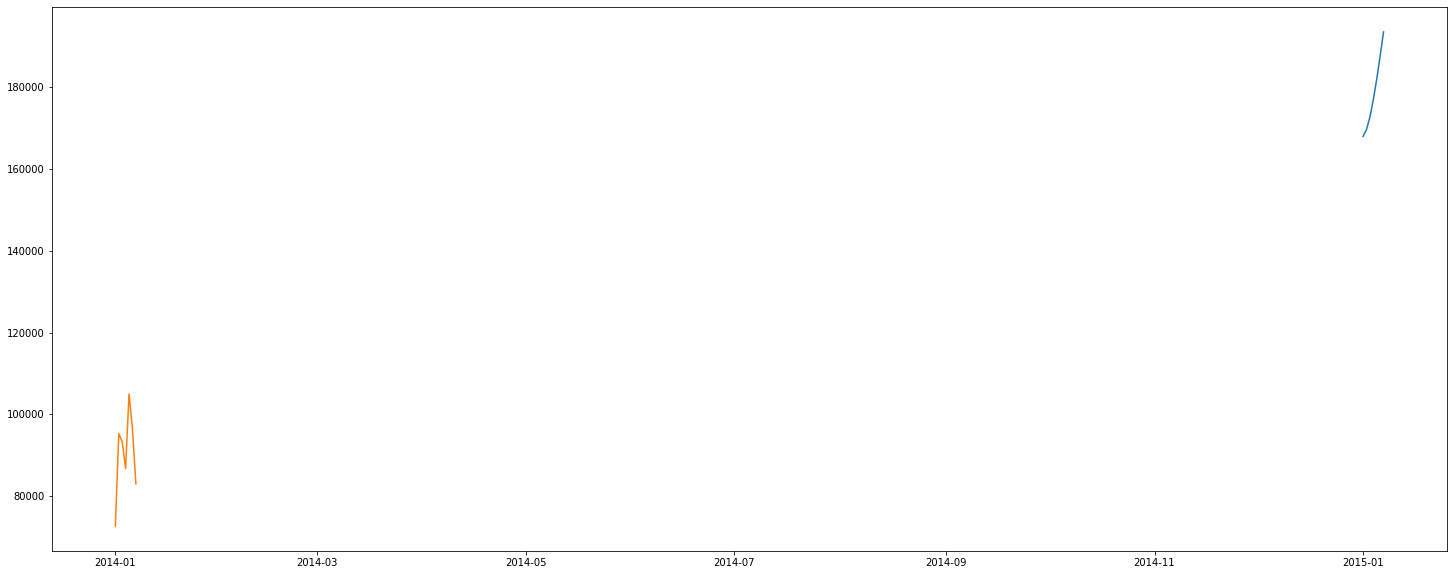

In [46]:
plt.plot(preds[0].loc[:,['ds', 'yhat']].copy().set_index('ds'))
plt.plot(df.iloc[preds[0].loc[:,['ds', 'yhat']].index].set_index('ds').y);

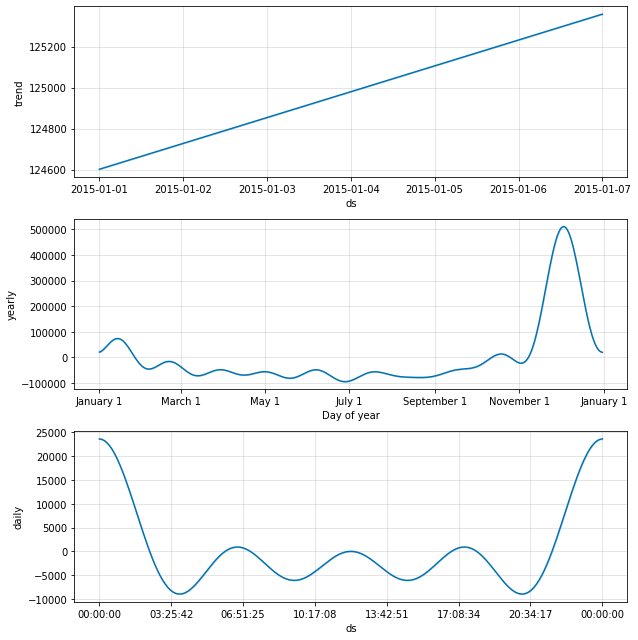

In [47]:
fig = m.plot_components(preds[0])

In [48]:
x = forecast.loc[:,['ds', 'yhat']] # get entire forecast for comparison if needed
x.set_index('ds', inplace=True)
# x.plot();

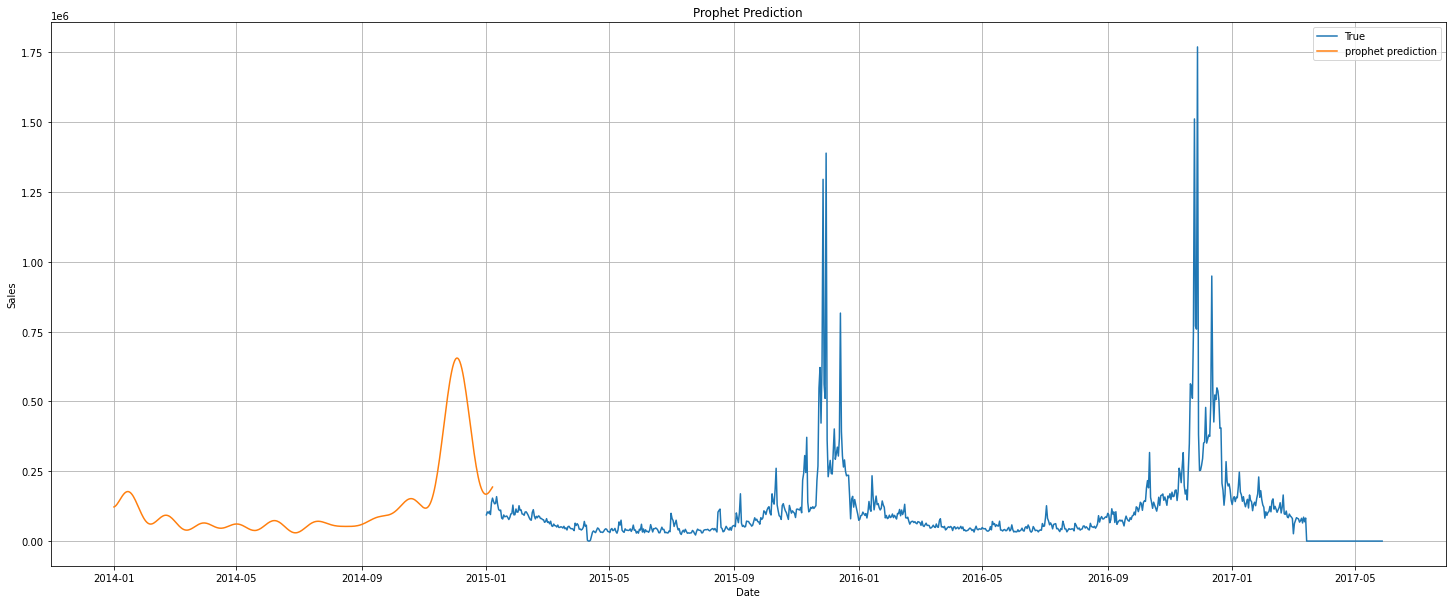

In [49]:
plt.plot(test.y, label='True')
plt.plot(pred.yhat, label='prophet prediction')
plt.title("Prophet Prediction")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid()
plt.legend();

In [50]:
from fbprophet.plot import add_changepoints_to_plot

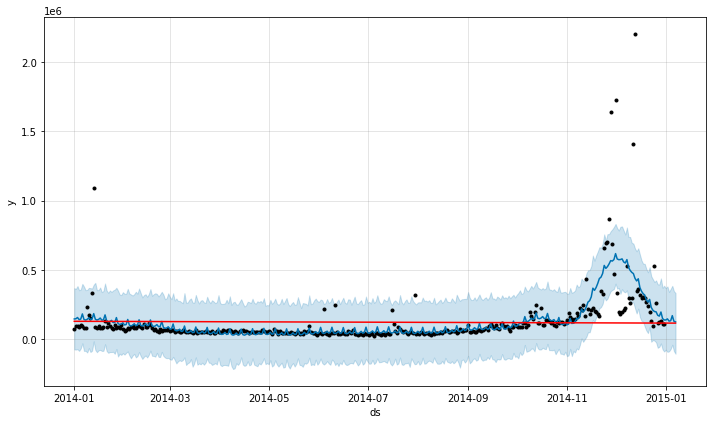

In [51]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [52]:
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [63]:
res = test.join(pred, how='inner')

In [65]:
print("The R2 score is:\t{:0.3f}".format(r2_score(res.y, res.yhat)))
r2_test = r2_score(res.y, res.yhat)
print("The Adjusted R2 score is:\t{:0.3f}".format(adj_r2_score(r2_test, len(res.y), 1)))

The R2 score is:	-8.662
The Adjusted R2 score is:	-10.594


In [67]:
rmse_prophet = mean_squared_error(res.y, res.yhat)

#### LSTM

In [68]:
df.set_index('ds', inplace=True) # for LSTM we use the datetime as index, not a column

In [77]:
split_date = '2015-01-01'

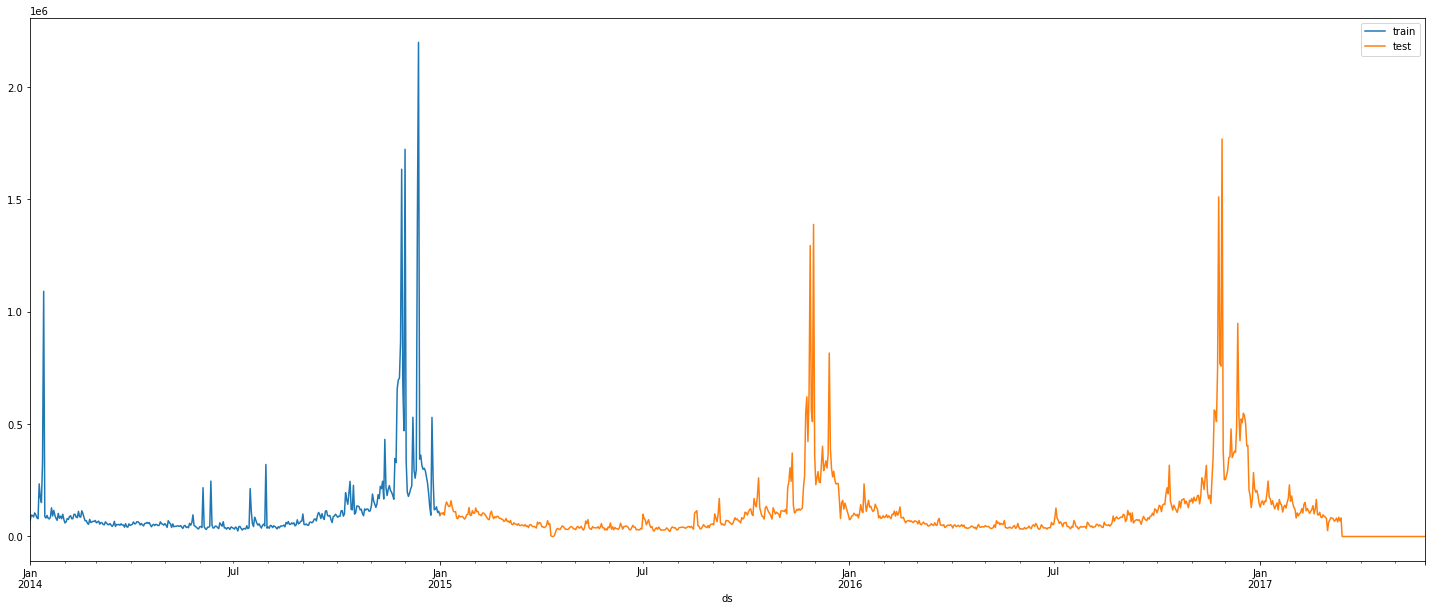

In [78]:
train = df.loc[:split_date]
test = df.loc[split_date:]
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [79]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [80]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [83]:
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, LSTM
from tensorflow.python.keras.callbacks import EarlyStopping

### Process the data for LSTM

In [84]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, 1)
X_tst_t = X_test.reshape(X_test.shape[0], 1, 1)

In [85]:
model_lstm = Sequential()
model_lstm.add(LSTM(32, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=10, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/10
365/365 [==============================] - 2s 1ms/step - loss: 0.0067
Epoch 2/10
365/365 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 3/10
365/365 [==============================] - 0s 1ms/step - loss: 0.0063
Epoch 4/10
365/365 [==============================] - 0s 1ms/step - loss: 0.0061
Epoch 5/10
365/365 [==============================] - 0s 1ms/step - loss: 0.0060
Epoch 6/10
365/365 [==============================] - 0s 1ms/step - loss: 0.0059
Epoch 7/10
365/365 [==============================] - 0s 1ms/step - loss: 0.0059
Epoch 8/10
365/365 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 9/10
365/365 [==============================] - 1s 1ms/step - loss: 0.0058
Epoch 10/10
365/365 [==============================] - 1s 1ms/step - loss: 0.0057


The R2 score on the Train set is:	0.128
The Adjusted R2 score on the Train set is:	0.126

The R2 score on the Test set is:	-0.073
The Adjusted R2 score on the Test set is:	-0.075
877/877 [==============================] - 1s 671us/step - loss: 0.0047
LSTM: 0.004733


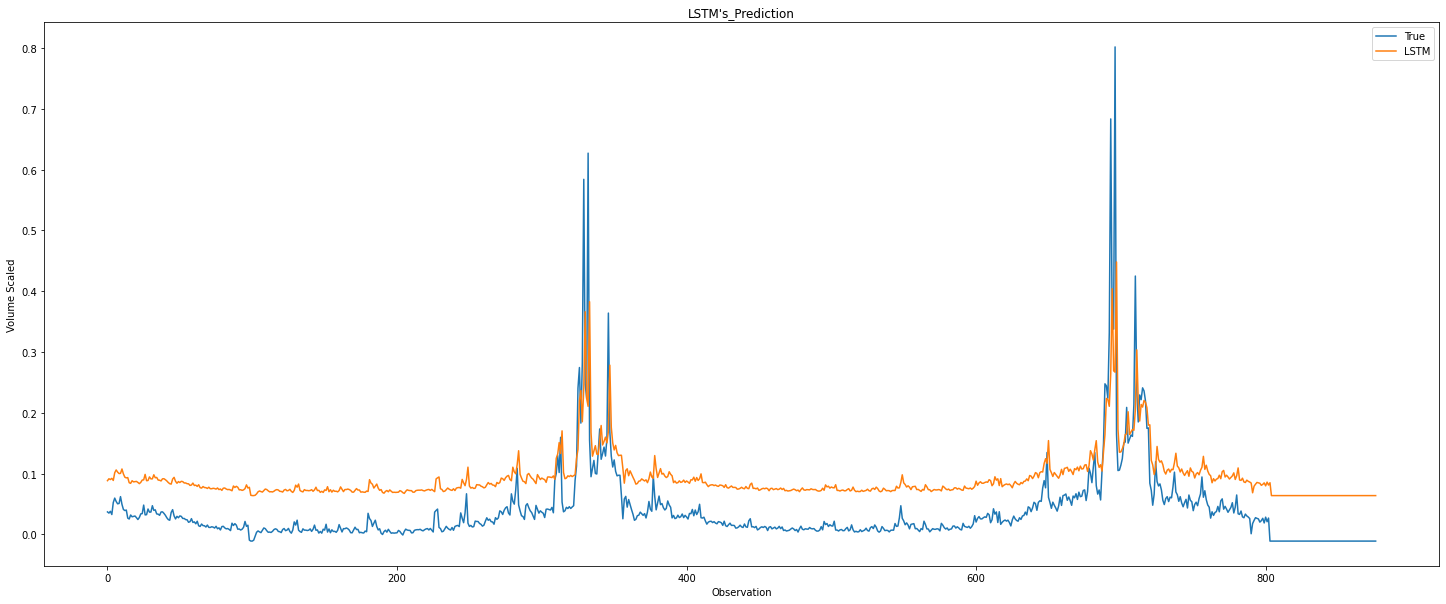

In [86]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

model_lstm.save('LSTM_NonShift.h5')
model_lstm = load_model('LSTM_NonShift.h5')
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

print('LSTM: %f'%score_lstm)

y_pred_test_lstm = model_lstm.predict(X_tst_t)

plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('Volume Scaled')
plt.legend();

In [87]:
results = pd.DataFrame({'pred': y_pred_test_lstm.flatten(),'true': y_test.flatten()}, index=test.index[1:])
results.head()

,pred,true
ds,,
2015-01-02,0.088218,0.036805
2015-01-03,0.091360,0.034851
2015-01-04,0.090107,0.037842
2015-01-05,0.092024,0.032501
2015-01-06,0.088600,0.052226


In [88]:
rmse_lstm = mean_squared_error(y_test, y_pred_test_lstm)

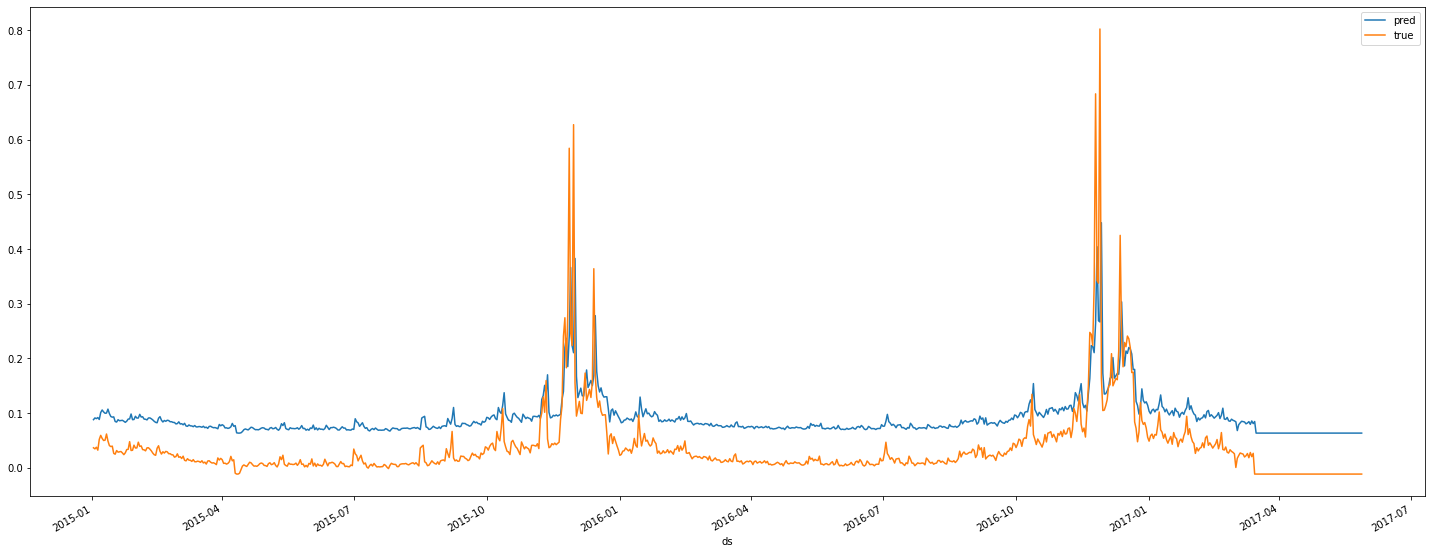

In [89]:
results.plot();

#### Who won?

In [90]:
print ('RMSE Prophet', rmse_prophet)
print ('RMSE LSTM', rmse_lstm)

RMSE Prophet 4499303928.506913
RMSE LSTM 0.004733141688645641
